# Assessing Support and Overlap with OverRule

## Motivation

Even if all other causal assumptions hold, we can only estimate causal effects for individuals with covariates $X$ that satisfy two conditions: 
* Support: Simply put, we require that we observe similar individuals in our dataset.  For discrete covariates $X$, this can be formalized as requiring that $$P(X) > 0$$
* Overlap: We require that there is some possibility of observing both the treatment and control for similar individuals.  Formally, we require that $$1 > P(T = 1 \mid X) > 0$$

OverRule [1] is a method for learning Boolean Rule Sets that characterize the set of individuals who satisfy both conditions, and is demonstrated in this notebook on some simple examples to build intuition.

## Acknowledgements

Code for OverRule is adapted (with minimal modifications, but some simplifications) from https://github.com/clinicalml/overlap-code, under the MIT License.

[1] Oberst, M., Johansson, F., Wei, D., Gao, T., Brat, G., Sontag, D., & Varshney, K. (2020). Characterization of
Overlap in Observational Studies. In S. Chiappa & R. Calandra (Eds.), Proceedings of the Twenty Third International
Conference on Artificial Intelligence and Statistics (Vol. 108, pp. 788–798). PMLR. https://arxiv.org/abs/1907.04138

In [1]:
import numpy as np
import pandas as pd

import dowhy.datasets
from dowhy import CausalModel
# Functional API
from dowhy.causal_refuters.assess_overlap import assess_support_and_overlap_overrule

# Data classes to configure ruleset optimization
from dowhy.causal_refuters.assess_overlap_overrule import SupportConfig, OverlapConfig

import matplotlib.pyplot as plt

# Illustration on a simple 2D example

## Setup 

In this example, we have a pair of binary covariates $X_1, X_2$, with simple violations of the above conditions:
* Support: There are no samples where $X_1 = X_2 = 1$, i.e., $P(X_1 = 1, X_2 = 1) = 0$ 
* Overlap: Only individuals with $X_1 = 0, X_2 = 0$ have a chance of recieving both treatment $(T = 1)$ and control $(T = 0)$

In [2]:
test_data = pd.DataFrame(
        np.array(
            [
                [0, 0, 1, 1],
                [0, 0, 0, 0],
                [0, 1, 1, 0],
                [1, 0, 0, 0],
            ]
            * 50
        ),
        columns=["X1", "X2", "T", "Y"],
    )

We can visualize these patterns as follows, where we **add some jitter** to the values to makes things easier to see

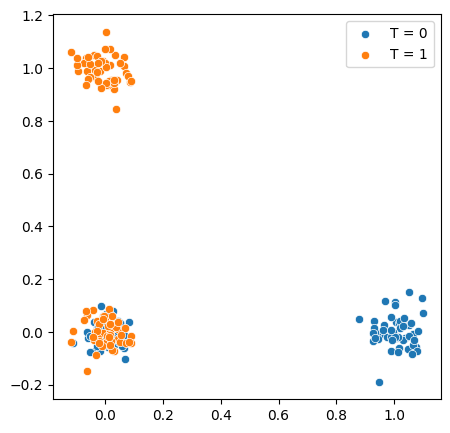

In [3]:
rng = np.random.default_rng(0)
jitter_data = test_data.copy()
jitter_data['X1'] = jitter_data['X1'] + rng.normal(0, 0.05, size=(200,)) 
jitter_data['X2'] = jitter_data['X2'] + rng.normal(0, 0.05, size=(200,)) 

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for t in [0, 1]:
    this_data = jitter_data.query('T == @t')
    ax.scatter(this_data['X1'], this_data['X2'], label=f'T = {t}', edgecolor='w', linewidths=0.5)

plt.legend()
plt.show()

Notice how the only region where overlap holds is when $X_1 = X_2 = 0$.

## Using OverRule as a refuter

This method is currently implemented as a refutation method, though it can also be accessed through the functional API.  We illustrate both methods below, before discussing their arguments.

Note that OverRule returns rules in Disjuntive Normal Form (DNF), which can be read as an OR of ANDs, and are given when `print(refute)` is called.

### Example usage using CausalModel

In [4]:
model = CausalModel(
    data=test_data,
    treatment="T",
    outcome="Y",
    common_causes=['X1', 'X2']
)

In [5]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")

In [6]:
refute = model.refute_estimate(identified_estimand, estimate, method_name='assess_overlap')

In [7]:
print(refute)

Rules cover 50.0% of all samples
Overall, 50.0% of samples meet the criteria for inclusion in the overlap set, defined as: Covered by support rules and propensity score in (0.10, 0.90)
Rules capture 100.0% of samples which meet these criteria

DETAILED RULES:
SUPPORT Rules: Found 2 rule(s), covering 100.0% of samples
	    Rule #0: (not X2)
		 [Covers 75.0% of samples]
	 OR Rule #1: (not X1)
		 AND (X2)
		 [Covers 25.0% of samples]
OVERLAP Rules: Found 1 rule(s), covering 50.0% of samples
	    Rule #0: (not X1)
		 AND (not X2)
		 [Covers 50.0% of samples]



### Example usage using the Functional API



Note that the outcome $Y$ is not used as part of OverRule, so it is not required here.

In [8]:
refute = assess_support_and_overlap_overrule(data=test_data, backdoor_vars=['X1', 'X2'], treatment_name='T')

In [9]:
print(refute)

Rules cover 50.0% of all samples
Overall, 50.0% of samples meet the criteria for inclusion in the overlap set, defined as: Covered by support rules and propensity score in (0.10, 0.90)
Rules capture 100.0% of samples which meet these criteria

DETAILED RULES:
SUPPORT Rules: Found 2 rule(s), covering 100.0% of samples
	    Rule #0: (not X1)
		 [Covers 75.0% of samples]
	 OR Rule #1: (X1)
		 AND (not X2)
		 [Covers 25.0% of samples]
OVERLAP Rules: Found 1 rule(s), covering 50.0% of samples
	    Rule #0: (not X1)
		 AND (not X2)
		 [Covers 50.0% of samples]



### Only fitting support or overlap rules

You can also run OverRule to **only** learn either support or overlap rules, by passing in either `support_only=True` or `overlap_only=True`.

In [10]:
refute = model.refute_estimate(identified_estimand, estimate, method_name='assess_overlap', support_only=True)

In [11]:
print(refute)

Rules cover 100.0% of all samples

DETAILED RULES:
SUPPORT Rules: Found 2 rule(s), covering 100.0% of samples
	    Rule #0: (not X1)
		 [Covers 75.0% of samples]
	 OR Rule #1: (not X2)
		 [Covers 75.0% of samples]
No Overlap Rules Fitted (support_only=True).


In [12]:
refute = model.refute_estimate(identified_estimand, estimate, method_name='assess_overlap', overlap_only=True)

In [13]:
print(refute)

Rules cover 50.0% of all samples
Overall, 50.0% of samples meet the criteria for inclusion in the overlap set, defined as: Covered by support rules and propensity score in (0.10, 0.90)
Rules capture 100.0% of samples which meet these criteria

DETAILED RULES:
No Support Rules Fitted (overlap_only=True).OVERLAP Rules: Found 1 rule(s), covering 50.0% of samples
	    Rule #0: (not X1)
		 AND (not X2)
		 [Covers 50.0% of samples]



### Configuration

OverRule can be configured by passing in the following arguments
* `overlap_eps`: This should be a number $\epsilon$ in (0, 0.5) which defines the overlap region as those points where $P(T = 1 \mid X)$ is in $(\epsilon, 1 - \epsilon)$.

* `cat_feats`: A list of any categorical features (automatically inferred if dtype is object).

* `support_config`: A `SupportConfig` (see below), which controls optimization parameters

* `overlap_config`: An `OverlapConfig` (see below), which controls optimization parameters

In [14]:
from dowhy.causal_refuters.assess_overlap_overrule import SupportConfig, OverlapConfig

In [17]:
support_config = SupportConfig()
print(support_config)

SupportConfig(n_ref_multiplier=1.0, alpha=0.98, lambda0=0.01, lambda1=0.001, K=20, D=20, B=10, iterMax=10, num_thresh=9, solver='ECOS', rounding='greedy_sweep')


In [19]:
overlap_config = OverlapConfig()
print(overlap_config)

OverlapConfig(alpha=0.95, lambda0=0.001, lambda1=0.001, K=20, D=20, B=10, iterMax=10, num_thresh=9, solver='ECOS', rounding='greedy_sweep')


For `SupportConfig` and `OverlapConfig`, the defaults are generally sensible, but some more important to understand, and are detailed below.
* `alpha`: 
    + For learning support rules, we require that at least an `alpha` fraction of the original data is included, while minimizing the volume of the resulting support set.  
    + For learning overlap rules, at least an `alpha` fraction of the "overlap points" must be included, while excluding as many non-overlap points as possible.  Here, the "overlap points" are defined as those where $P(T = 1 \mid X)$ is within `[overlap_eps, 1 - overlap_eps]`, estimated using an XGBClassifier.
* `lambda0`, `lambda1`: These are regularization terms which control the complexity of the final rules. 
    + `lambda0` is a penalty added for every new rule (which can contain multiple literals).  For instance, `(not X1) AND (not X2)` is a single rule. 
    + `lambda1` is a penalty added for every literal.  For instance, `(not X1) AND (not X2)` contains two literals.
* `num_thresh`: OverRule turns all features into binary rules before learning rulesets.  For continuous variables, it does so (by default) by converting into deciles.  This default behavior can be changed via changing the number of thresholds, or specifying a dictionary (in `thresh_override`) that maps features to a `np.ndarray` of thresholds.